In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score

from tcn import TCN, tcn_full_summary

import warnings
warnings.filterwarnings("ignore")

import datetime

streaming=pd.read_csv('cpu4.csv')
for i in range(len(streaming)):
    streaming['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(streaming['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in streaming.columns if i not in ['timestamp']]
for col in cols:
    streaming[col]=pd.to_numeric(streaming[col])
streaming['timestamp'] = pd.to_datetime(streaming['timestamp'])
streaming.tail()

2022-11-07 12:02:49.027779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,timestamp,value,label
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0
17567,2016-09-23 19:55:00,-0.036137,0


In [2]:
max_features=4
x=streaming['value']
t=streaming['timestamp']
label=streaming['label']

Text(0.5, 1.0, 'Streaming Dataset')

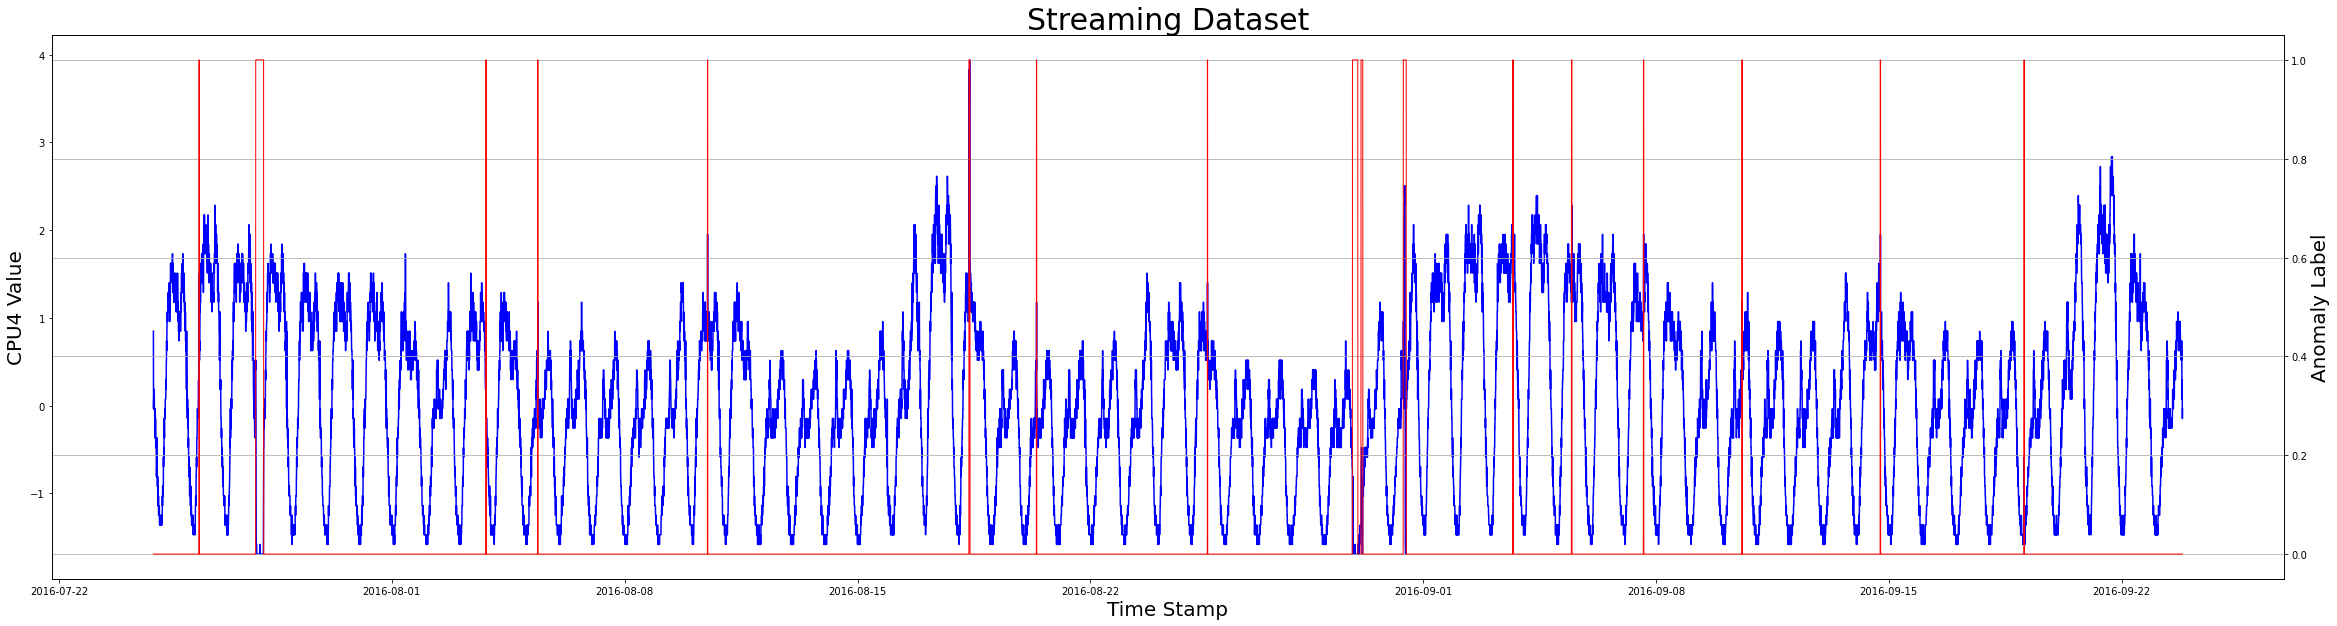

In [3]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(t, x, color='blue')
ax2a.plot(t, label, color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

Start date is:  2016-07-24 20:00:00
End date is:  2016-09-23 19:55:00
Length of full data: 17568


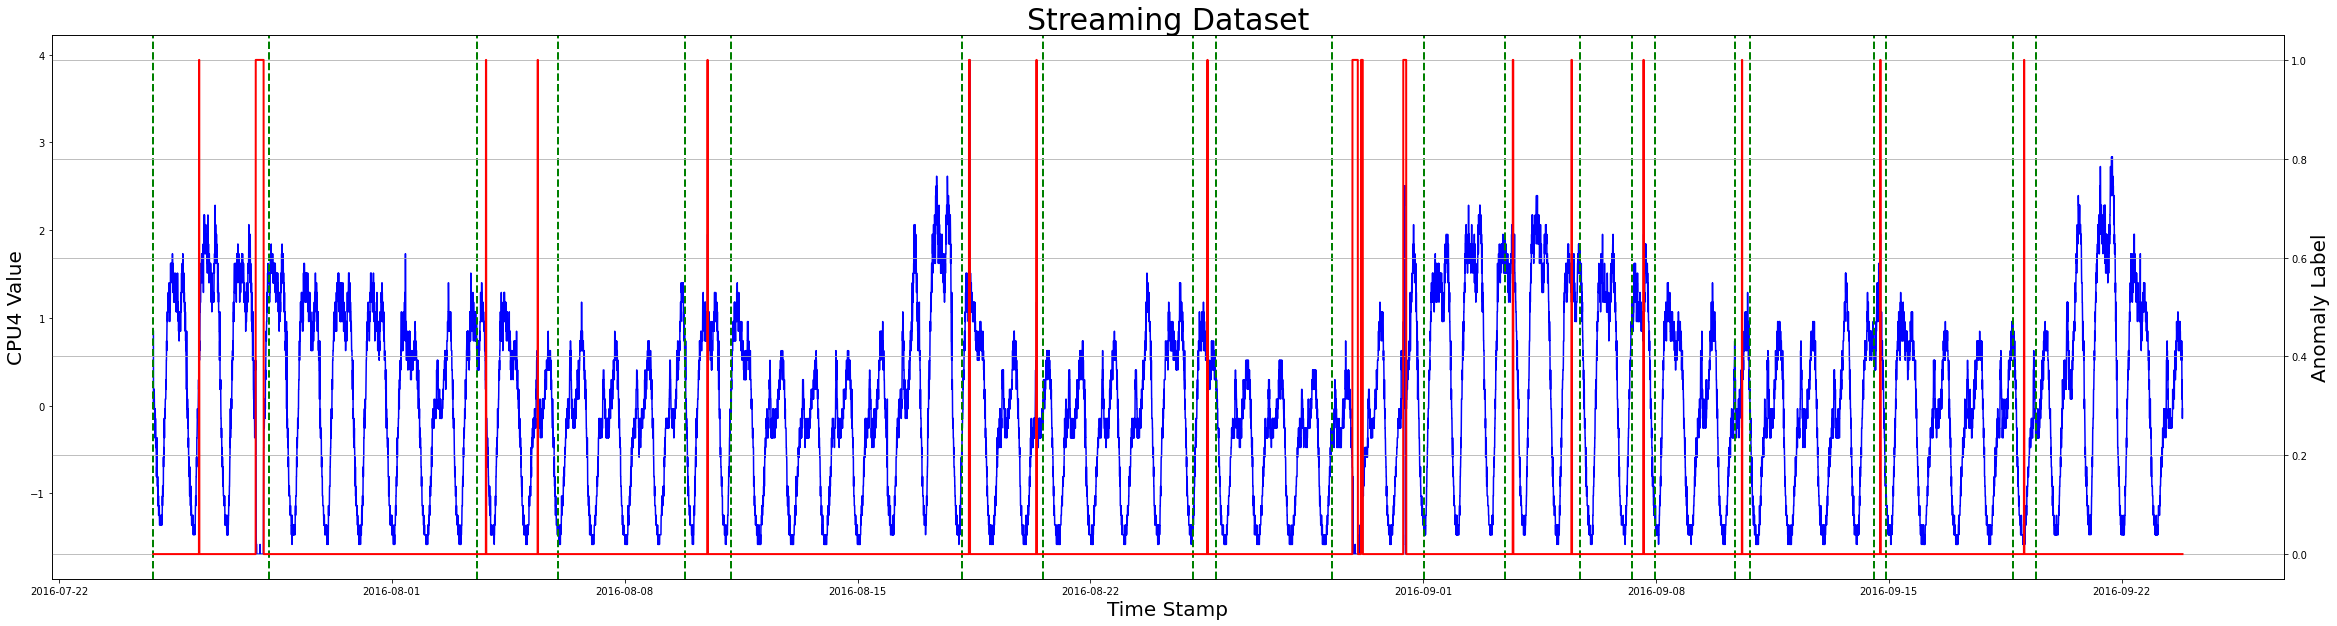

In [4]:
split1a=t[0]
split1b=t[1000]

split2a=t[2800]
split2b=t[3500]

split3a=t[4600]
split3b=t[5000]

split4a=t[7000]
split4b=t[7700]

split5a=t[9000]
split5b=t[9200]

split6a=t[10200]
split6b=t[11000]

split7a=t[11700]
split7b=t[12350]

split8a=t[12800]
split8b=t[13000]

split9a=t[13690]
split9b=t[13820]

split10a=t[14900]
split10b=t[15000]

split11a=t[16100]
split11b=t[16300]

fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(t, x, color='blue')
ax2a.plot(t, label, color='red', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

ax2d.axvline(split1a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split1b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split2b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split3b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split4b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split5b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split6b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split7a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split7b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split8a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split8b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split9a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split9b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split10a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split10b, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split11a, color='green', linestyle='dashed', linewidth='2')
ax2d.axvline(split11b, color='green', linestyle='dashed', linewidth='2')


plt.grid()

plt.title('Streaming Dataset', fontsize=30)

print("Start date is: ", t.min())
print("End date is: ", t.max())
print(f"Length of full data: {len(streaming)}")

Text(0.5, 1.0, 'Streaming Dataset')

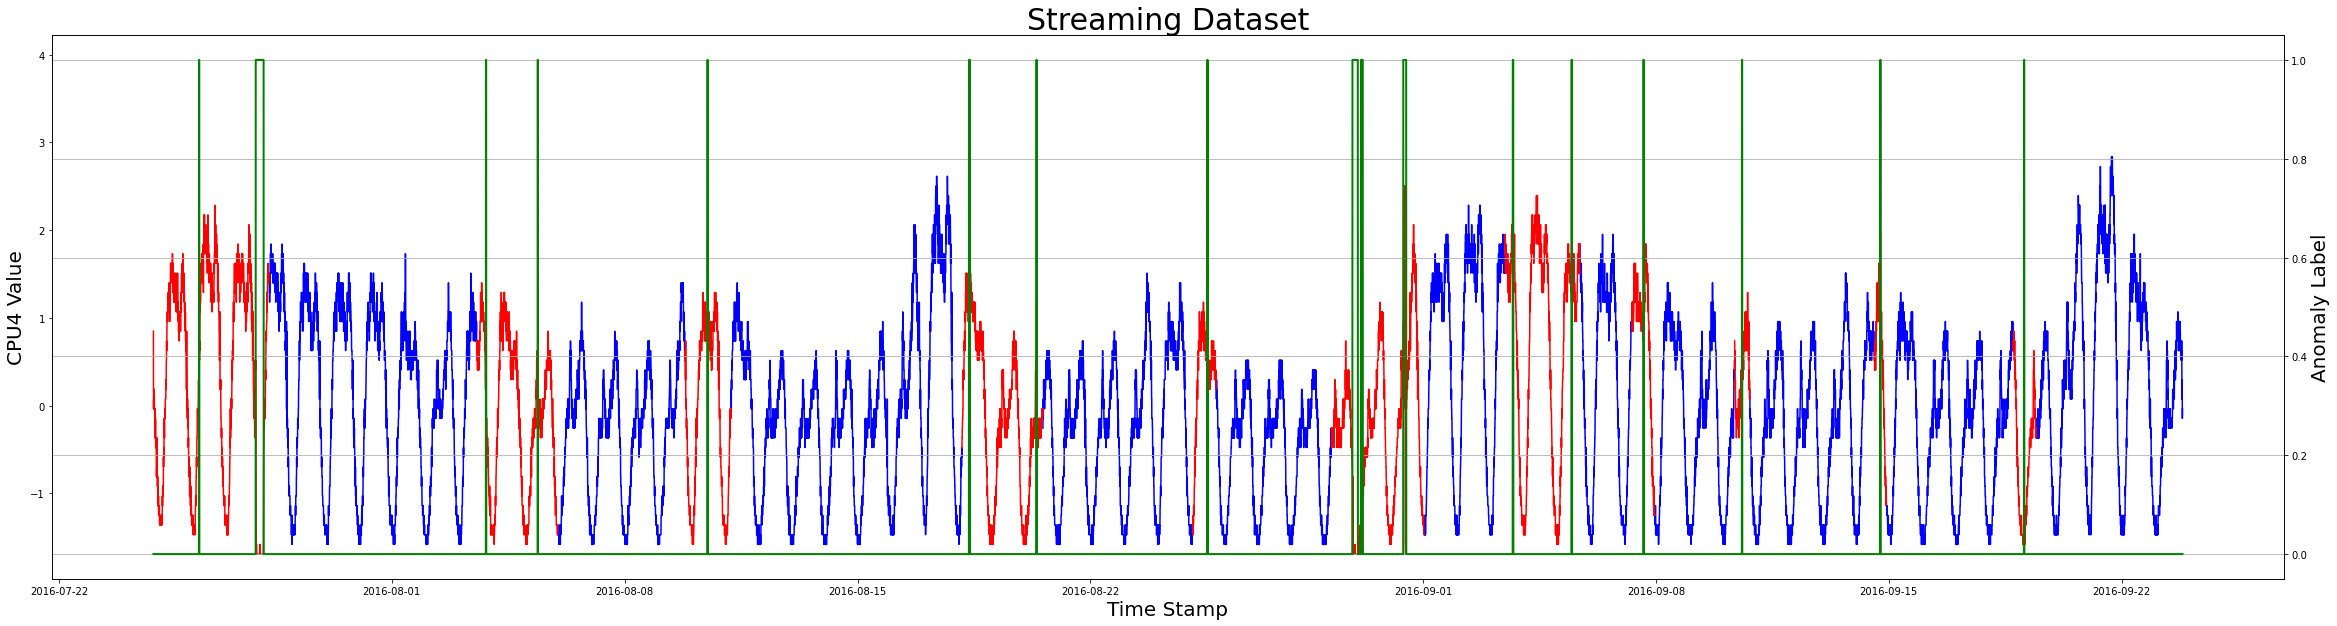

In [5]:
# Training intervals
train1 = streaming.loc[(t > split1b) & (t < split2a)]
train2 = streaming.loc[(t > split2b) & (t < split3a)]
train3 = streaming.loc[(t > split3b) & (t < split4a)]
train4 = streaming.loc[(t > split4b) & (t < split5a)]
train5 = streaming.loc[(t > split5b) & (t < split6a)]
train6 = streaming.loc[(t > split6b) & (t < split7a)]
train7 = streaming.loc[(t > split7b) & (t < split8a)]
train8 = streaming.loc[(t > split8b) & (t < split9a)]
train9 = streaming.loc[(t > split9b) & (t < split10a)]
train10 = streaming.loc[(t > split10b) & (t < split11a)]
train11 = streaming.loc[t > split11b]


# Testing intervals
test1 = streaming.loc[(t >= split1a) & (t <= split1b)]
test2 = streaming.loc[(t >= split2a) & (t <= split2b)]
test3 = streaming.loc[(t >= split3a) & (t <= split3b)]
test4 = streaming.loc[(t >= split4a) & (t <= split4b)]
test5 = streaming.loc[(t >= split5a) & (t <= split5b)]
test6 = streaming.loc[(t >= split6a) & (t <= split6b)]
test7 = streaming.loc[(t >= split7a) & (t <= split7b)]
test8 = streaming.loc[(t >= split8a) & (t <= split8b)]
test9 = streaming.loc[(t >= split9a) & (t <= split9b)]
test10 = streaming.loc[(t >= split10a) & (t <= split10b)]
test11 = streaming.loc[(t >= split11a) & (t <= split11b)]

fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(train1['timestamp'], train1['value'], color='blue')
ax2d.plot(test1['timestamp'], test1['value'], color='red')
ax2d.plot(train2['timestamp'], train2['value'], color='blue')
ax2d.plot(test2['timestamp'], test2['value'], color='red')
ax2d.plot(train3['timestamp'], train3['value'], color='blue')
ax2d.plot(test3['timestamp'], test3['value'], color='red')
ax2d.plot(train4['timestamp'], train4['value'], color='blue')
ax2d.plot(test4['timestamp'], test4['value'], color='red')
ax2d.plot(train5['timestamp'], train5['value'], color='blue')
ax2d.plot(test5['timestamp'], test5['value'], color='red')
ax2d.plot(train6['timestamp'], train6['value'], color='blue')
ax2d.plot(test6['timestamp'], test6['value'], color='red')
ax2d.plot(train7['timestamp'], train7['value'], color='blue')
ax2d.plot(test7['timestamp'], test7['value'], color='red')
ax2d.plot(train8['timestamp'], train8['value'], color='blue')
ax2d.plot(test8['timestamp'], test8['value'], color='red')
ax2d.plot(train9['timestamp'], train9['value'], color='blue')
ax2d.plot(test9['timestamp'], test9['value'], color='red')
ax2d.plot(train10['timestamp'], train10['value'], color='blue')
ax2d.plot(test10['timestamp'], test10['value'], color='red')
ax2d.plot(train11['timestamp'], train11['value'], color='blue')
ax2d.plot(test11['timestamp'], test11['value'], color='red')

ax2a.plot(t, label, color='green', linewidth='2')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [6]:
# Preprocessing: normalize the data in mean and variance
scaler = StandardScaler()
scaler = scaler.fit(pd.concat([train1, train2, train3, train4, train5, train6, train7, train8, train9, train10, train11])[['value']]) #To normalize the mean and variance

train1['value'] = scaler.transform(train1['value'].to_numpy().reshape(-1,1))
train2['value'] = scaler.transform(train2['value'].to_numpy().reshape(-1,1))
train3['value'] = scaler.transform(train3['value'].to_numpy().reshape(-1,1))
train4['value'] = scaler.transform(train4['value'].to_numpy().reshape(-1,1))
train5['value'] = scaler.transform(train5['value'].to_numpy().reshape(-1,1))
train6['value'] = scaler.transform(train6['value'].to_numpy().reshape(-1,1))
train7['value'] = scaler.transform(train7['value'].to_numpy().reshape(-1,1))
train8['value'] = scaler.transform(train8['value'].to_numpy().reshape(-1,1))
train9['value'] = scaler.transform(train9['value'].to_numpy().reshape(-1,1))
train10['value'] = scaler.transform(train10['value'].to_numpy().reshape(-1,1))
train11['value'] = scaler.transform(train11['value'].to_numpy().reshape(-1,1))

trainSeqs = [train1, train2, train3, train4, train5, train6, train7, train8, train9, train10, train11]

# Avoid leakage of information between train and test dataset

test1['value'] = scaler.transform(test1['value'].to_numpy().reshape(-1,1))
test2['value'] = scaler.transform(test2['value'].to_numpy().reshape(-1,1))
test3['value'] = scaler.transform(test3['value'].to_numpy().reshape(-1,1))
test4['value'] = scaler.transform(test4['value'].to_numpy().reshape(-1,1))
test5['value'] = scaler.transform(test5['value'].to_numpy().reshape(-1,1))
test6['value'] = scaler.transform(test6['value'].to_numpy().reshape(-1,1))
test7['value'] = scaler.transform(test7['value'].to_numpy().reshape(-1,1))
test8['value'] = scaler.transform(test8['value'].to_numpy().reshape(-1,1))
test9['value'] = scaler.transform(test9['value'].to_numpy().reshape(-1,1))
test10['value'] = scaler.transform(test10['value'].to_numpy().reshape(-1,1))
test11['value'] = scaler.transform(test11['value'].to_numpy().reshape(-1,1))

testSeqs = [test1, test2, test3, test4, test5, test6, test7, test8, test9, test10, test11]

# Compute the train to test ratio

learn_ratio = pd.concat(trainSeqs).shape[0] / streaming.shape[0]
print("Training dataset percentage: " "{:.2f}" "%".format(learn_ratio*100))

test_ratio = pd.concat(testSeqs).shape[0] / streaming.shape[0]
print("Testing dataset percentage: " "{:.2f}" "%".format(test_ratio*100))

Training dataset percentage: 71.02%
Testing dataset percentage: 28.98%


In [7]:
trainSeqs

[               timestamp     value  label
 1001 2016-07-28 07:25:00  1.500612      0
 1002 2016-07-28 07:30:00  1.613902      0
 1003 2016-07-28 07:35:00  1.500612      0
 1004 2016-07-28 07:40:00  1.387321      0
 1005 2016-07-28 07:45:00  1.387321      0
 ...                  ...       ...    ...
 2795 2016-08-03 12:55:00  1.047451      0
 2796 2016-08-03 13:00:00  0.934161      0
 2797 2016-08-03 13:05:00  1.047451      0
 2798 2016-08-03 13:10:00  0.934161      0
 2799 2016-08-03 13:15:00  0.707580      0
 
 [1799 rows x 3 columns],
                timestamp     value  label
 3501 2016-08-05 23:45:00 -1.444934      0
 3502 2016-08-05 23:50:00 -1.331643      0
 3503 2016-08-05 23:55:00 -1.444934      0
 3504 2016-08-06 00:00:00 -1.444934      0
 3505 2016-08-06 00:05:00 -1.444934      0
 ...                  ...       ...    ...
 4595 2016-08-09 18:55:00  0.934161      0
 4596 2016-08-09 19:00:00  1.047451      0
 4597 2016-08-09 19:05:00  0.820870      0
 4598 2016-08-09 19:10:00 

In [8]:
testSeqs

[               timestamp     value  label
 0    2016-07-24 20:00:00  0.934161      0
 1    2016-07-24 20:05:00  0.027839      0
 2    2016-07-24 20:10:00  0.141129      0
 3    2016-07-24 20:15:00  0.141129      0
 4    2016-07-24 20:20:00  0.027839      0
 ...                  ...       ...    ...
 996  2016-07-28 07:00:00  1.613902      0
 997  2016-07-28 07:05:00  1.500612      0
 998  2016-07-28 07:10:00  1.613902      0
 999  2016-07-28 07:15:00  1.613902      0
 1000 2016-07-28 07:20:00  1.613902      0
 
 [1001 rows x 3 columns],
                timestamp     value  label
 2800 2016-08-03 13:20:00  0.707580      0
 2801 2016-08-03 13:25:00  0.820870      0
 2802 2016-08-03 13:30:00  0.594290      0
 2803 2016-08-03 13:35:00  0.707580      0
 2804 2016-08-03 13:40:00  0.707580      0
 ...                  ...       ...    ...
 3496 2016-08-05 23:20:00 -1.331643      0
 3497 2016-08-05 23:25:00 -1.444934      0
 3498 2016-08-05 23:30:00 -1.444934      0
 3499 2016-08-05 23:35:00 

In [9]:
TIME_STEPS = 32 #Default 32
sample_predict=1

# Create the sequences of size TIME_STEPS to feed the sequential model
def to_sequences(x, y, TIME_STEPS=1):
    x_values = []
    y_values = []

    for i in range(len(x)-TIME_STEPS):
        x_values.append(x.iloc[i:(i+TIME_STEPS)].values)
        y_values.append(y.iloc[i+sample_predict:(i+TIME_STEPS+sample_predict)].values)
        
    return np.array(x_values), np.array(y_values)

# Stack the sequences obtained in each period to create a single training tensor
trainX = np.array([])
trainY = np.array([])
testX = np.array([])
testY = np.array([])

for train in trainSeqs:
    x, y = to_sequences(train[['value']], train[['value']], TIME_STEPS)
    trainX = np.vstack([trainX, x]) if trainX.size else x
    trainY = np.vstack([trainY, y]) if trainY.size else y
    
for test in testSeqs:
    x, y = to_sequences(test[['value']], test[['value']], TIME_STEPS)
    testX = np.vstack([testX, x]) if testX.size else x
    testY = np.vstack([testY, y]) if testY.size else y

In [10]:
print(f"Train X shape: {trainX.shape[0]} batches, {trainX.shape[1]} values for each batch, {trainX.shape[2]} dimensional batch")
print(f"Train Y shape: {trainY.shape[0]} batches, {trainY.shape[1]} values for each batch")
print(f"Test X shape: {testX.shape[0]} batches, {testX.shape[1]} values for each batch, {testX.shape[2]} dimensional batch")
print(f"Test Y shape: {testY.shape[0]} batches, {testY.shape[1]} values for each batch")

Train X shape: 12125 batches, 32 values for each batch, 1 dimensional batch
Train Y shape: 12125 batches, 32 values for each batch
Test X shape: 4739 batches, 32 values for each batch, 1 dimensional batch
Test Y shape: 4739 batches, 32 values for each batch


In [11]:
print("Build model...")
#What is the shape of the output of TCN?

nb_filters=128
filter_size=2 #Use 30 for default
lr = 0.0001

model = Sequential()

#model.add(layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(TCN(nb_filters=nb_filters, kernel_size=filter_size, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False, input_shape=(None, trainX.shape[2])))

model.add(layers.Dropout(rate=0.2))

model.add(layers.RepeatVector(trainX.shape[1])) # Focus on this trainX.shape[1] as default

#model.add(layers.LSTM(128, return_sequences=True))
model.add(TCN(nb_filters=nb_filters, kernel_size=filter_size, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=True, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))

model.add(layers.Dropout(rate=0.2))

model.add(layers.TimeDistributed(layers.Dense(1)))

model.add(Dense(1, activation='relu'))

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mae', optimizer=opt)

model.summary()

Build model...


2022-11-07 12:02:56.956225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 128)               494080    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 32, 128)          0         
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 32, 128)           526336    
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 32, 1)            129       
 ibuted)                                                

Train...
Epoch 1/50
341/341 [==============================] - 60s 169ms/step - loss: 120.5946 - val_loss: 1.0627
Epoch 2/50
341/341 [==============================] - 59s 173ms/step - loss: 0.8797 - val_loss: 1.0616
Epoch 3/50
341/341 [==============================] - 62s 182ms/step - loss: 51.8811 - val_loss: 1.0663
Epoch 4/50
341/341 [==============================] - 62s 183ms/step - loss: 0.8873 - val_loss: 1.0616
Epoch 5/50
341/341 [==============================] - 66s 193ms/step - loss: 0.8129 - val_loss: 1.0616
Epoch 6/50
341/341 [==============================] - 64s 188ms/step - loss: 0.8082 - val_loss: 1.0616
Epoch 7/50
341/341 [==============================] - 64s 188ms/step - loss: 0.8044 - val_loss: 1.0616
Graph Results...


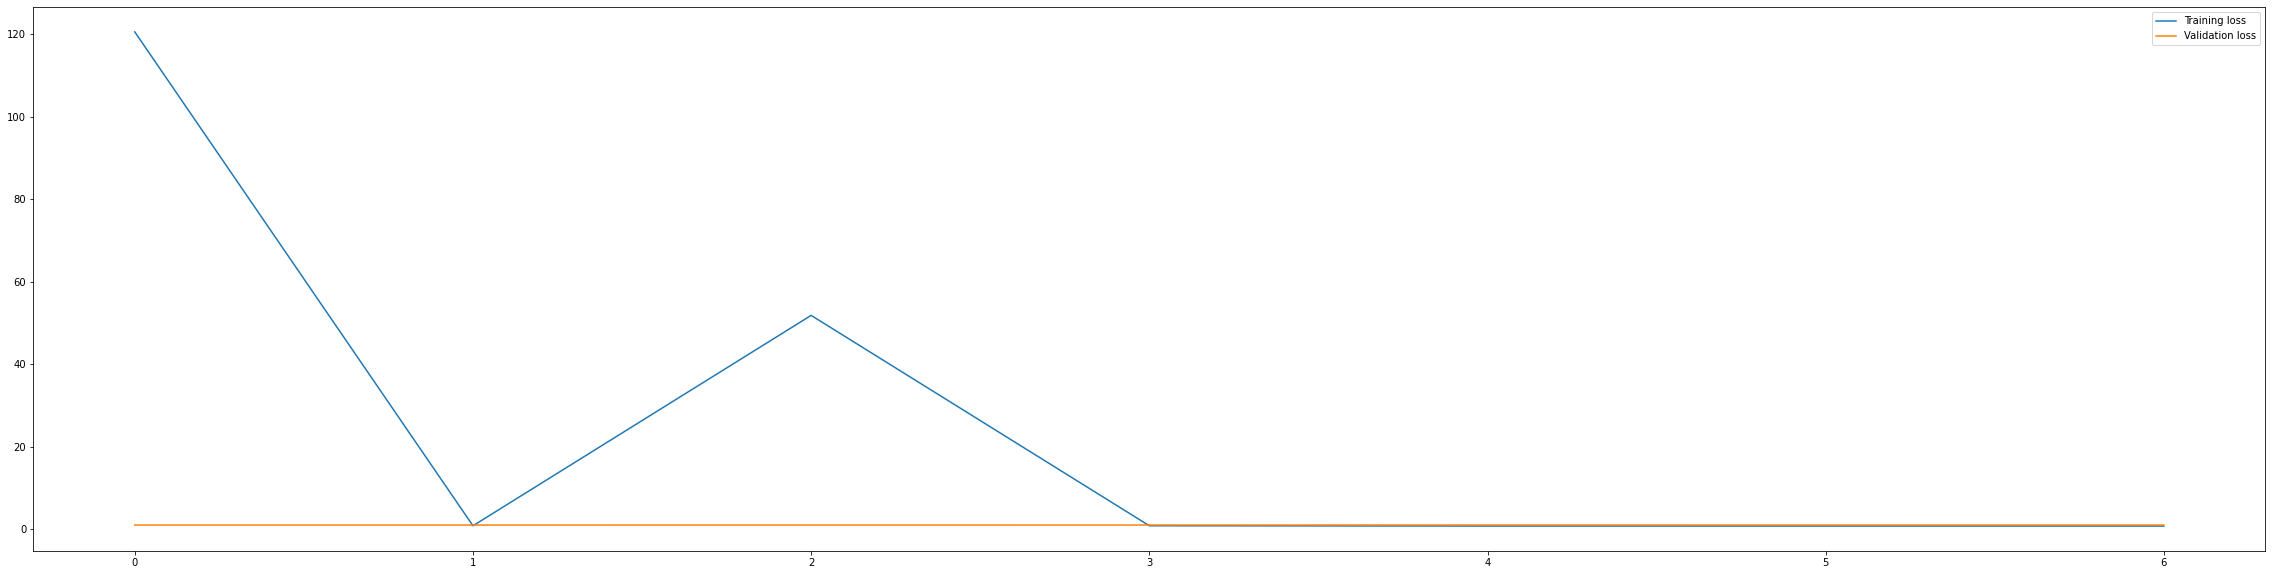

In [12]:
print('Train...')
# Fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1, shuffle=True, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])

# Plot the training and validation loss 
print("Graph Results...")
plt.figure(figsize=(40,10))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

379/379 [==============================] - 47s 122ms/step


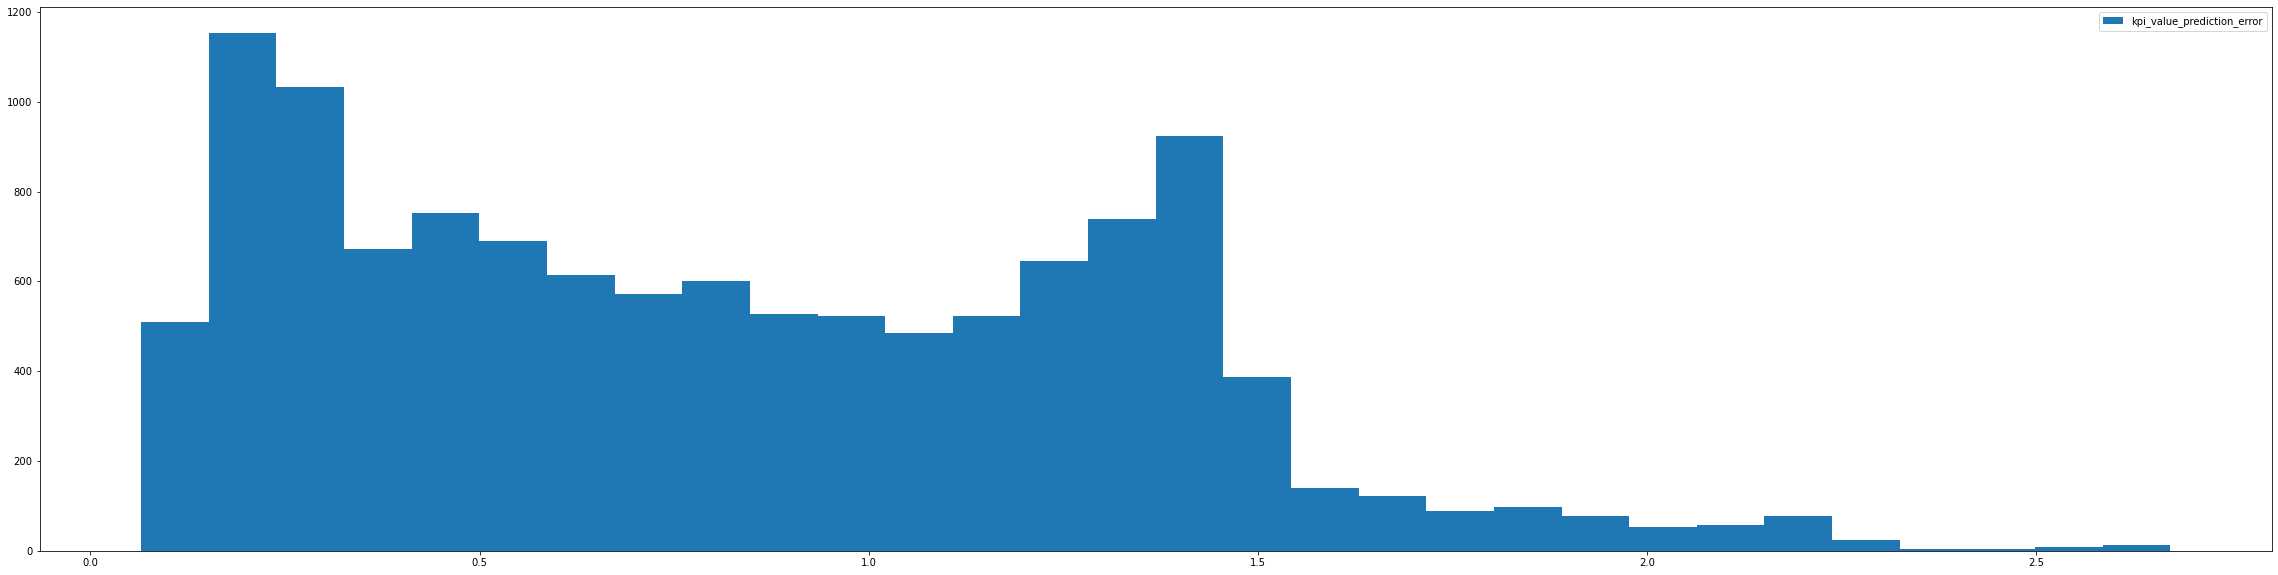

In [13]:
# Plot a histogram of the reconstruction error in the training dataset to decide a threshold

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(trainMAE, bins=30);
plt.legend(['kpi_value_prediction_error'])
threshold_trainMAE = 0.95 #or Define 90% value of max as threshold.

In [14]:
print(f"Train Predict Shape {trainPredict.shape[0]}")
print(f"Train Y Shape {trainY.shape[0]}")

Train Predict Shape 12125
Train Y Shape 12125


149/149 [==============================] - 18s 120ms/step


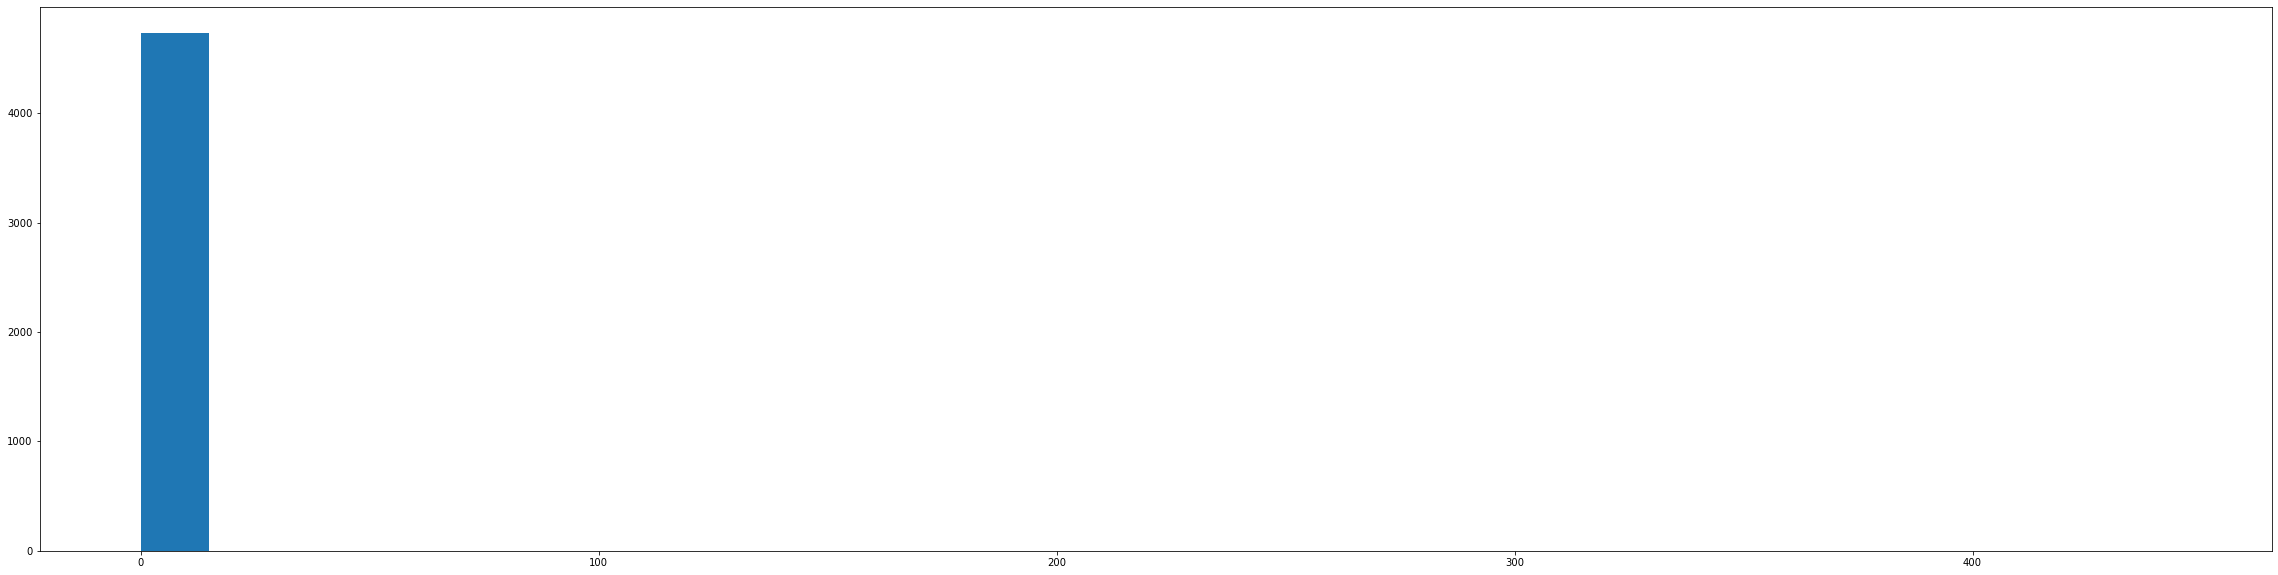

In [15]:
# Histogram of the testing MAE
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.figure(figsize=(40,10));
plt.hist(testMAE, bins=30);

In [16]:
print(testPredict[0])
print("  ")
print(testY[0])
print("  ")
print(np.abs(testPredict[0]-testY[0]))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
  
[[ 0.02783904]
 [ 0.14112924]
 [ 0.14112924]
 [ 0.02783904]
 [ 0.25441944]
 [ 0.02783904]
 [ 0.25441944]
 [ 0.14112924]
 [ 0.02783904]
 [ 0.02783904]
 [ 0.02783904]
 [-0.19874135]
 [-0.19874135]
 [-0.31203155]
 [-0.31203155]
 [ 0.02783904]
 [-0.31203155]
 [-0.08545115]
 [-0.31203155]
 [-0.42532175]
 [-0.42532175]
 [-0.42532175]
 [-0.42532175]
 [-0.42532175]
 [-0.53861195]
 [-0.76519234]
 [-0.76519234]
 [-0.65190215]
 [-0.65190215]
 [-0.76519234]
 [-0.76519234]
 [-0.31203155]]
  
[[0.02783904]
 [0.14112924]
 [0.14112924]
 [0.02783904]
 [0.25441944]
 [0.02783904]
 [0.25441944]
 [0.14112924]
 [0.02783904]
 [0.02783904]
 [0.02783904]
 [0.19874135]
 [0.19874135]
 [0.31203155]
 [0.31203155]
 [0.02783904]
 [0.31203155]
 [0.08545115]
 [0.31203155]
 [0.42532175]
 [0.42532175]
 [0.42532175]
 [0.42532175

In [17]:
# Detect anomaly if the reconstruction loss for a sample is greater than the threshold

anomaly_df = pd.concat([seq[TIME_STEPS:] for seq in testSeqs])
anomaly_df['testMAE'] = testMAE
anomaly_df['threshold_trainMAE'] = threshold_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['threshold_trainMAE']

In [18]:
testPredict.shape[0]

4739

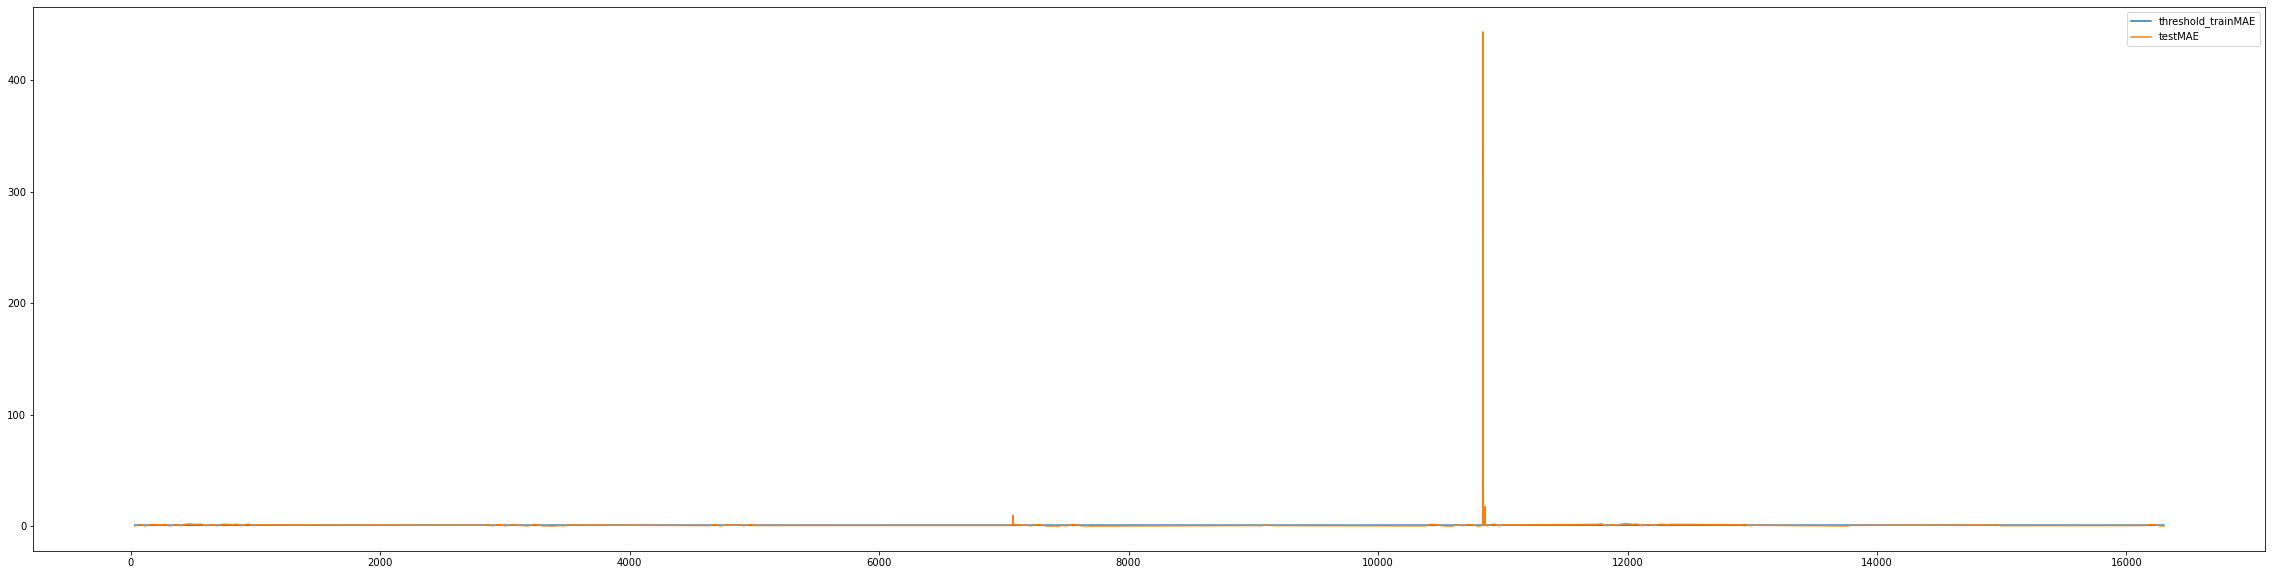

In [19]:
# Plot the test MAE
plt.figure(figsize=[40, 10])
anomaly_df['threshold_trainMAE'].plot()
anomaly_df['testMAE'].plot()
plt.legend()

In [20]:
# Detect the anomaly points inside the dataset
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

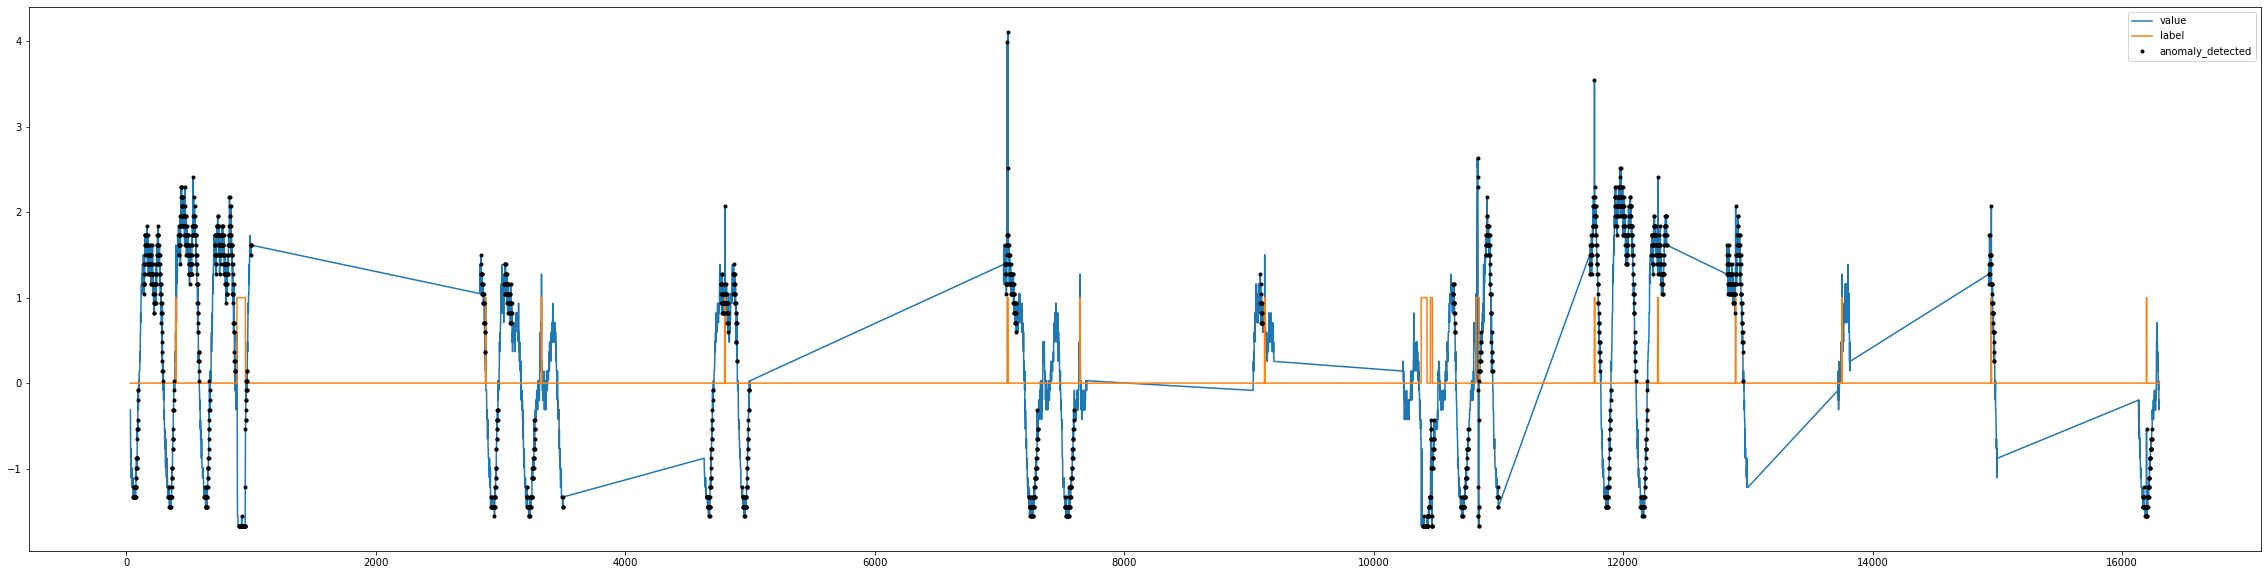

In [21]:
#Plot the anomalies
plt.figure(figsize=(40,10))
anomaly_df['value'].plot()
anomaly_df['label'].plot()
anomalies['value'].plot(marker='.', linestyle='None', label='anomaly_detected', color='black')
plt.legend()

In [22]:
# Inspect the resulting dataset
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4739 entries, 32 to 16300
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           4739 non-null   datetime64[ns]
 1   value               4739 non-null   float64       
 2   label               4739 non-null   int64         
 3   testMAE             4739 non-null   float64       
 4   threshold_trainMAE  4739 non-null   float64       
 5   anomaly             4739 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 226.8 KB


In [23]:
anomaly_df

,timestamp,value,label,testMAE,threshold_trainMAE,anomaly
32,2016-07-24 22:40:00,-0.312032,0,0.318750,0.95,False
33,2016-07-24 22:45:00,-0.651902,0,0.338252,0.95,False
34,2016-07-24 22:50:00,-0.878483,0,0.361294,0.95,False
35,2016-07-24 22:55:00,-0.878483,0,0.384336,0.95,False
36,2016-07-24 23:00:00,-0.878483,0,0.410919,0.95,False
...,...,...,...,...,...,...
16296,2016-09-19 10:00:00,-0.312032,0,0.286705,0.95,False
16297,2016-09-19 10:05:00,-0.198741,0,0.286705,0.95,False
16298,2016-09-19 10:10:00,-0.198741,0,0.286705,0.95,False
16299,2016-09-19 10:15:00,-0.198741,0,0.283165,0.95,False


In [24]:
# Compute the precision in the test dataset
precision=precision_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"Precision: {round(precision, 3)}")
# Compute the recall in the test dataset
recall=recall_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"Recall: {round(recall, 3)}")
# Compute the F1 score in the test dataset
f1_score=f1_score(anomaly_df['label'], anomaly_df['anomaly'])
print(f"F1 Score: {round(f1_score, 3)}")

Precision: 0.061
Recall: 0.689
F1 Score: 0.112
